In [1]:
import warnings
from pathlib import Path

import pandas as pd

from plot_utils import load_metrics, plot_map_per_config

warnings.filterwarnings('ignore', category=UserWarning)

#### Create configs for loading evalzoo results

In [2]:
RESULTS_DIR = Path("../2.evalzoo/results/")
MERTRICS_FILENAME = "metrics_level_1_ref"
FIGSAVE_PATH = Path("output/mAP_visualizations")

METRICS_COLUMNS = {
    "sim_retrieval_average_precision_ref_i_mean_i": "mAP",
    "sim_retrieval_average_precision_ref_i_nlog10pvalue_mean_i": "-log(pvalue)",
    "sim_retrieval_average_precision_ref_i_nlog10qvalue_mean_i": "-log(qvalue)",
}

GROUPBY_COLUMNS = {
    "same_well_diff_pert": ["Metadata_Well"],
    "same_pert_diff_well": ["Metadata_JCP2022"],
    "same_well_same_pert": ["Metadata_Well", "Metadata_JCP2022"],
}

#### List which results to plot

`Note:` in this version, results without cc adjustment (panels 1 and 3) did not unclude CC as a feature, unlike CC-adjusted results (panels 2 and 4)

In [3]:
# All results combined, see https://github.com/alxndrkalinin/position-effect-correction/blob/1d7c0b9ba8e93b7adb81ecc9df70f444a944d43a/3.correct/3_compare_metrics_subset.ipynb

# metrics = {
#     # subset -> robustMAD -> feature select -> metrics
#     "subset->preprocess\t\t\t": {
#         "same_well_diff_pert": "0e4cd68f",
#         "same_pert_diff_well": "ceb5f02a",
#         "same_well_same_pert": "34fbd8a4",
#     },
#     # subset -> well correct -> robustMAD -> feature select -> metrics
#     "subset->well_correct->preprocess\t": {
#         "same_well_diff_pert": "82ad004e",
#         "same_pert_diff_well": "f5c36cb4",
#         "same_well_same_pert": "d66f1bce",
#     },
#     # well correct -> robustMAD -> feature select -> subset -> metrics
#     "well_correct->subset->preprocess\t": {
#         "same_well_diff_pert": "3ec971b2",
#         "same_pert_diff_well": "72f94e10",
#         "same_well_same_pert": "138739c0",
#     },
#     # subset -> robustMAD -> feature select -> cell count correct -> metrics
#     "subset->preprocess->cc_correct\t": {
#         "same_well_diff_pert": "3701ed2c",
#         "same_pert_diff_well": "440d5bda",
#         "same_well_same_pert": "a69994b0",
#     },
#     # subset -> cell count correct -> robustMAD -> feature select -> metrics
#     "subset->cc_correct->preprocess\t": {
#         "same_well_diff_pert": "d2311b58",
#         "same_pert_diff_well": "5f53102a",
#         "same_well_same_pert": "e2bf955d",
#     },
#     # subset -> cell count correct -> well correct -> robustMAD -> feature select -> metrics
#     "subset->cc_correct->well_correct->preprocess\t": {
#         "same_well_diff_pert": "304eb132",
#         "same_pert_diff_well": "1b22d880",
#         "same_well_same_pert": "faa6ba3e",
#     },
# }

In [4]:
metrics = {
    # subset -> robustMAD -> feature select -> metrics
    "subset->preprocess\t\t\t": {
        "same_well_diff_pert": "0e4cd68f",
        "same_pert_diff_well": "ceb5f02a",
        "same_well_same_pert": "34fbd8a4",
    },
    # subset -> cell count correct -> robustMAD -> feature select -> metrics
    "subset->cc_adjust->preprocess\t": {
        "same_well_diff_pert": "d2311b58",
        "same_pert_diff_well": "5f53102a",
        "same_well_same_pert": "e2bf955d",
    },
    # subset -> well correct -> robustMAD -> feature select -> metrics
    "subset->well_correct->preprocess\t": {
        "same_well_diff_pert": "82ad004e",
        "same_pert_diff_well": "f5c36cb4",
        "same_well_same_pert": "d66f1bce",
    },
    # subset -> cell count correct -> well correct -> robustMAD -> feature select -> metrics
    "subset->cc_adjust->well_correct->preprocess\t": {
        "same_well_diff_pert": "304eb132",
        "same_pert_diff_well": "1b22d880",
        "same_well_same_pert": "faa6ba3e",
    },
}

#### Load evalzoo metrics

In [5]:
metrics_df = load_metrics(metrics, METRICS_COLUMNS, GROUPBY_COLUMNS, RESULTS_DIR, MERTRICS_FILENAME)
print(metrics_df.shape)

(16232, 8)


#### Plot mAP scatterplots and densities

same_well_diff_pert subset->preprocess			 mmAP: 0.0636 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->cc_adjust->preprocess	 mmAP: 0.0583 p<0.05: 0.0217 (8/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.114 p<0.05: 0.25 (92/368)
same_well_diff_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.379 p<0.05: 0.723 (266/368)


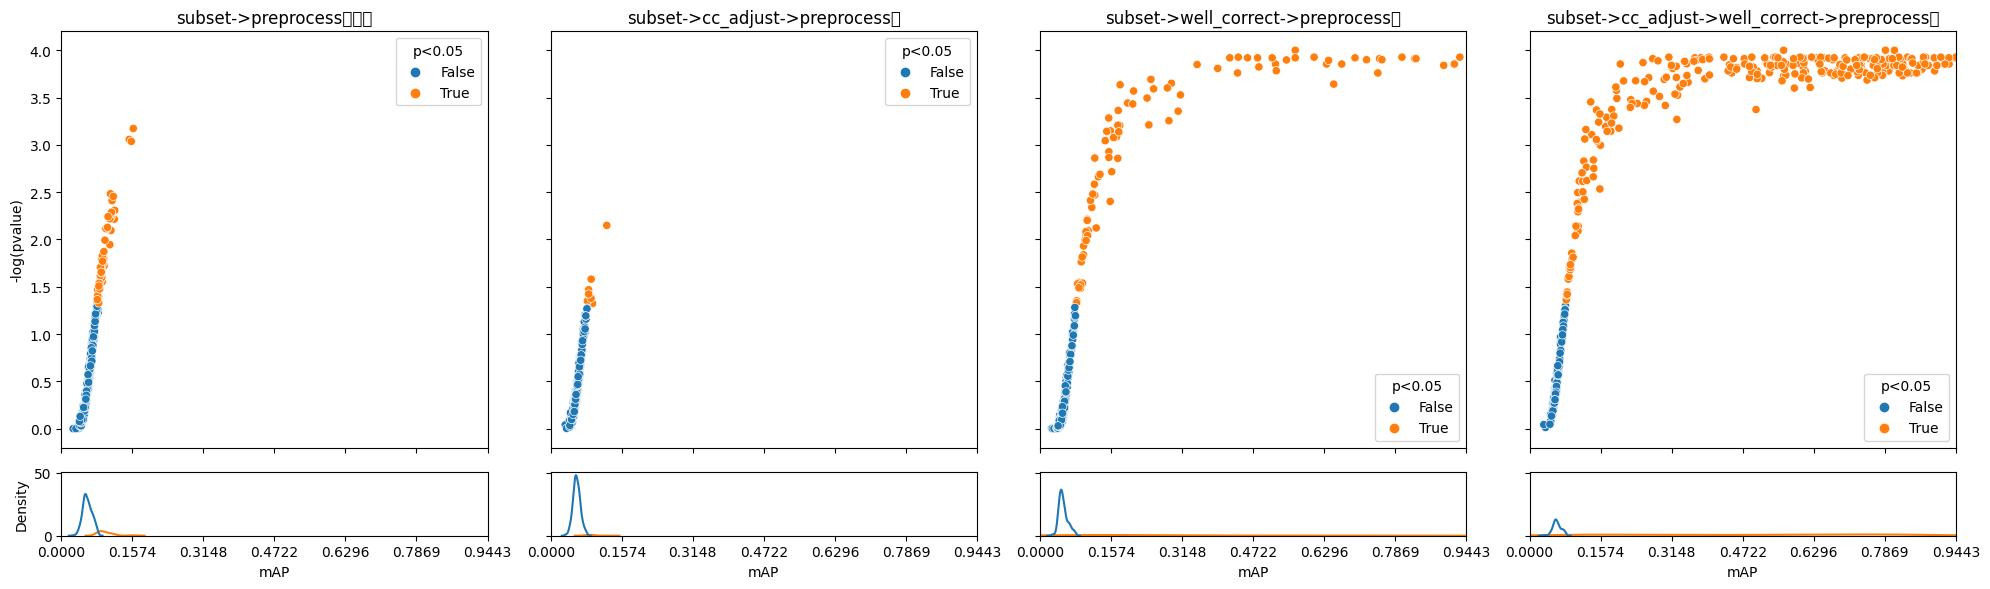

same_pert_diff_well subset->preprocess			 mmAP: 0.00974 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->cc_adjust->preprocess	 mmAP: 0.0202 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0166 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->cc_adjust->well_correct->preprocess	 mmAP: 0.00834 p<0.05: 0.0 (0/37)


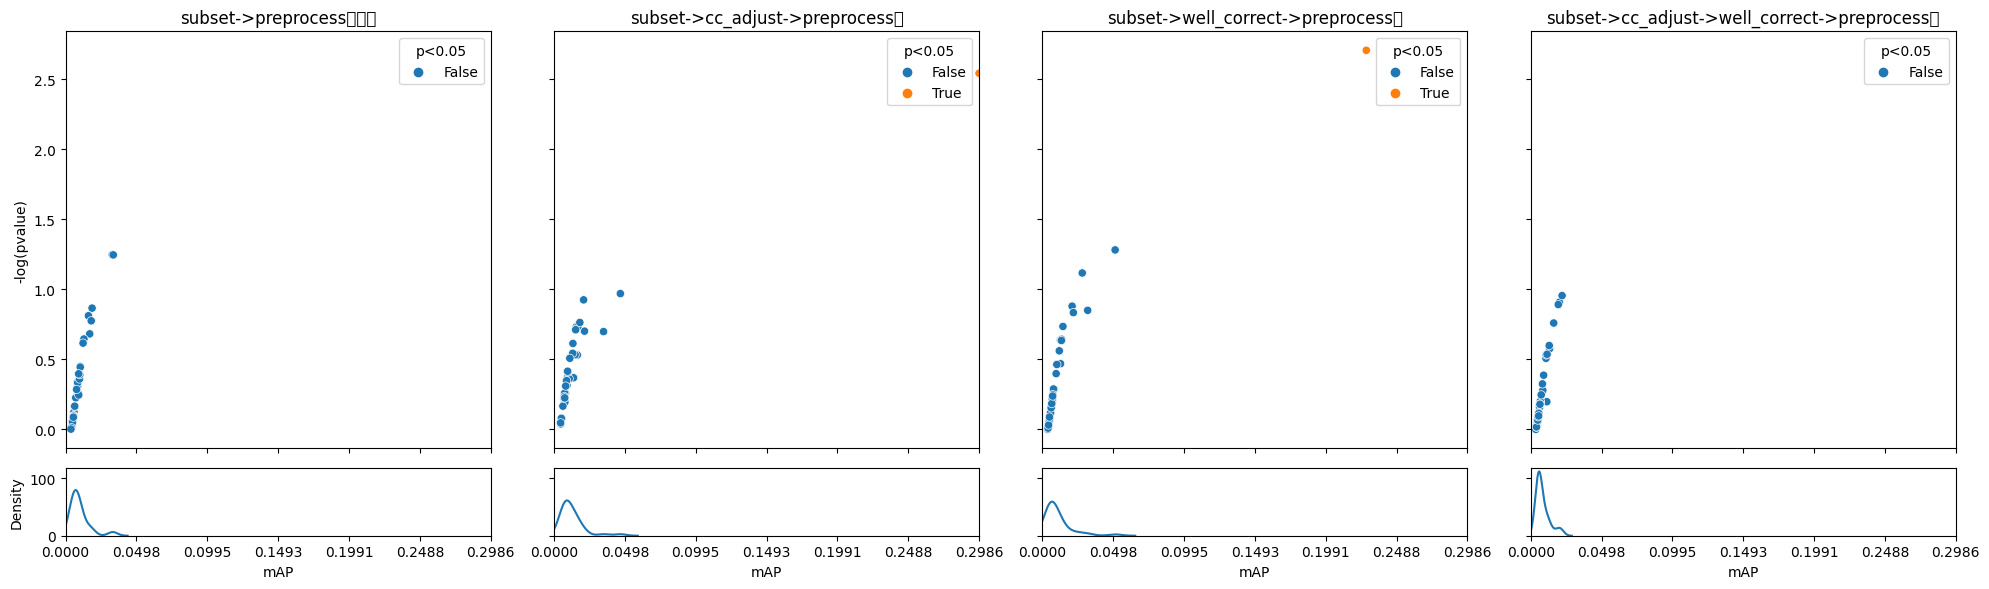

same_well_same_pert subset->preprocess			 mmAP: 0.195 p<0.05: 0.903 (3297/3653)
same_well_same_pert subset->cc_adjust->preprocess	 mmAP: 0.0856 p<0.05: 0.417 (1524/3653)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.286 p<0.05: 0.93 (3397/3653)
same_well_same_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.538 p<0.05: 0.989 (3612/3653)


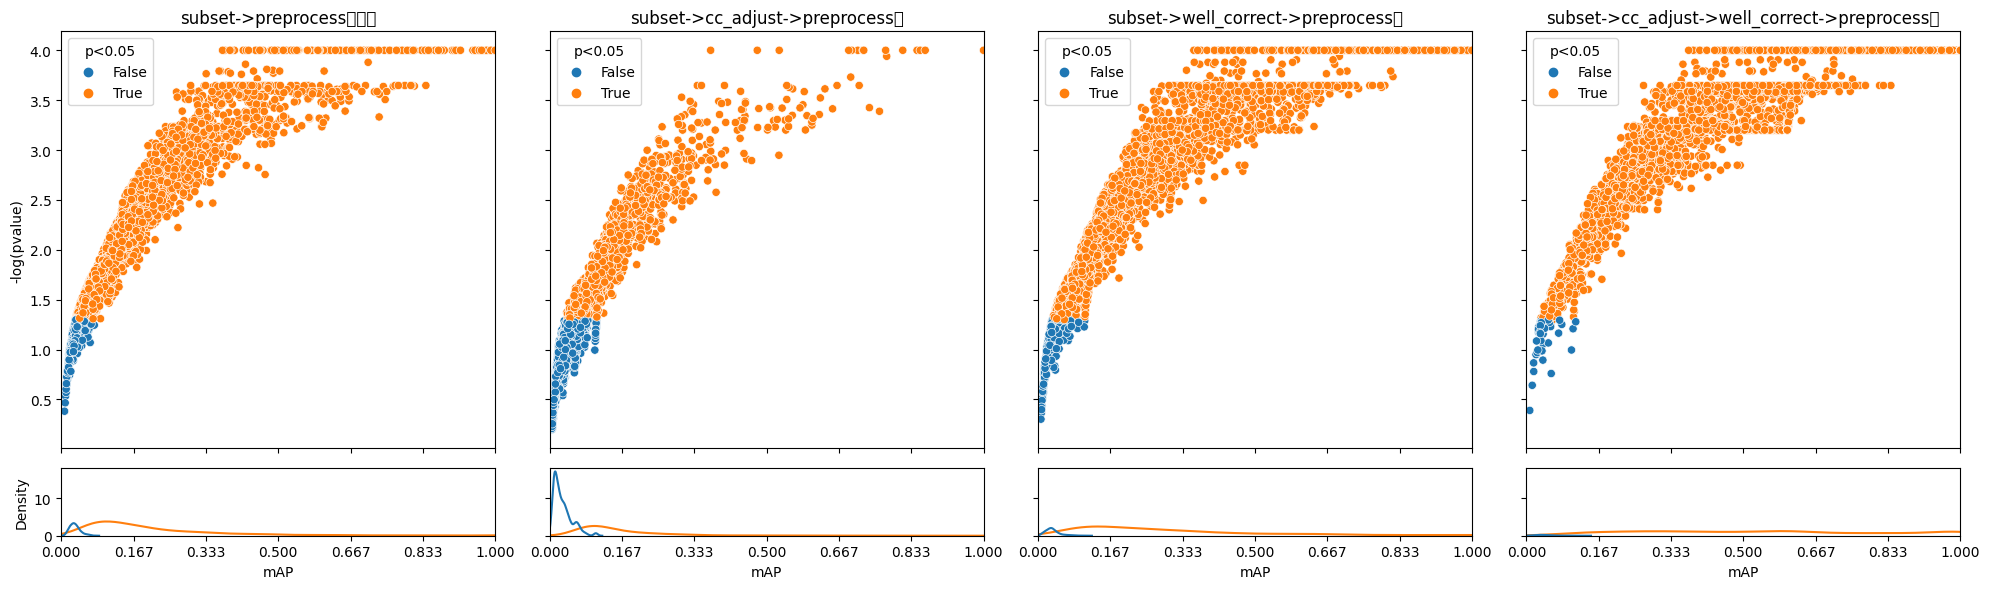

In [6]:
for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    plot_map_per_config(config_df, config, figsave_path=FIGSAVE_PATH / "cell_count_adjusted")

### Explore calculated metrics on low/high cell count variability ORFs

In [7]:
ann_df_trt_low_cvar = pd.read_parquet("../1.load/output/subset_profiles_low_cvar_metadata.parquet")
ann_df_trt_low_cvar

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,48.712002,46.077000,46.318001,46.028999,46.393002,46.639000,47.831001,46.651001,48.021000,2021_08_09_Batch11
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,61.765999,57.683998,58.122002,57.683998,58.137001,58.535999,60.215000,58.625999,60.560001,2021_08_09_Batch11
2,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,51.533001,49.242001,49.653000,49.251999,49.708000,50.063999,51.639999,50.113998,51.570000,2021_08_09_Batch11
3,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,55.993000,52.728001,53.193001,52.875999,53.160000,53.438000,54.987999,53.695000,55.131001,2021_08_09_Batch11
4,JCP2022_900392,ccsbBroad304_00423,ORF005089.1_TRC304.1,pLX_304,NM_001350.5,DAXX,1616,9606,death domain associated protein,100.0,...,69.890999,65.041000,65.753998,65.021004,65.661003,66.371002,68.185997,66.240997,68.414001,2021_08_09_Batch11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12993,JCP2022_915014,ccsbBroad304_16053,ORF001543.1_TRC304.1,pLX_304,NM_033364.4,MAATS1,89876,9606,MYCBP associated and testis expressed 1,99.8,...,38.591999,36.006001,36.087002,35.944000,36.014999,36.230999,37.034000,36.217999,37.087002,2021_05_17_Batch4
12994,JCP2022_915024,ccsbBroad304_16064,ORF006054.1_TRC304.1,pLX_304,NM_001077594.1,EXOC3L4,91828,9606,exocyst complex component 3 like 4,99.7,...,34.634998,32.501999,32.438999,32.453999,32.741001,32.606998,33.284000,32.604000,33.542999,2021_05_17_Batch4
12995,JCP2022_915028,ccsbBroad304_16068,ORF008706.1_TRC304.1,pLX_304,NM_001286829.2,NAPRT,93100,9606,nicotinate phosphoribosyltransferase,86.0,...,28.549000,26.635000,26.684000,26.680000,26.768999,26.844000,27.371000,26.933001,27.440001,2021_05_17_Batch4
12996,JCP2022_915030,ccsbBroad304_16070,ORF000807.1_TRC304.1,pLX_304,NM_144577.4,CCDC114,93233,9606,coiled-coil domain containing 114,69.1,...,25.540001,23.671000,23.777000,23.621000,23.673000,23.830000,24.438000,23.801001,24.225000,2021_05_17_Batch4


In [8]:
print("ORFs in subset profiles:", len(metrics_df["Metadata_JCP2022"].unique()))
print("ORFs in low cell count variability profiles:", len(ann_df_trt_low_cvar["Metadata_JCP2022"].unique()))

print("Overlap: ", len(set(metrics_df["Metadata_JCP2022"].unique()) & set(ann_df_trt_low_cvar["Metadata_JCP2022"].unique())))

ORFs in subset profiles: 3617
ORFs in low cell count variability profiles: 2588
Overlap:  2588


In [9]:
metrics_low_ccv_df = metrics_df[metrics_df["Metadata_JCP2022"].isin(ann_df_trt_low_cvar["Metadata_JCP2022"].unique())]
metrics_low_ccv_df

,Metadata_Well,mAP,-log(pvalue),-log(qvalue),config,subset,p<0.05,Metadata_JCP2022
2,NaN,0.005446,0.092631,0.002252,same_pert_diff_well,subset->preprocess\t\t\t,False,JCP2022_900475
8,NaN,0.003931,0.008459,0.002252,same_pert_diff_well,subset->preprocess\t\t\t,False,JCP2022_905771
10,NaN,0.009209,0.245796,0.002252,same_pert_diff_well,subset->preprocess\t\t\t,False,JCP2022_906612
12,NaN,0.016010,0.811801,0.002252,same_pert_diff_well,subset->preprocess\t\t\t,False,JCP2022_908657
13,NaN,0.005223,0.081303,0.002252,same_pert_diff_well,subset->preprocess\t\t\t,False,JCP2022_909454
...,...,...,...,...,...,...,...,...
3638,P15,0.340012,3.167560,3.012472,same_well_same_pert,subset->cc_adjust->well_correct->preprocess\t,True,JCP2022_904560
3639,P15,0.414745,3.263506,3.038096,same_well_same_pert,subset->cc_adjust->well_correct->preprocess\t,True,JCP2022_905030
3643,P16,0.224029,2.651012,2.572554,same_well_same_pert,subset->cc_adjust->well_correct->preprocess\t,True,JCP2022_901063
3648,P16,0.544733,3.647358,3.298984,same_well_same_pert,subset->cc_adjust->well_correct->preprocess\t,True,JCP2022_908199


In [10]:
metrics_high_ccv_df = metrics_df[~metrics_df["Metadata_JCP2022"].isin(ann_df_trt_low_cvar["Metadata_JCP2022"].unique())]
metrics_high_ccv_df

,Metadata_Well,mAP,-log(pvalue),-log(qvalue),config,subset,p<0.05,Metadata_JCP2022
0,A01,0.117580,2.214167,0.809879,same_well_diff_pert,subset->preprocess\t\t\t,True,NaN
1,A02,0.110061,2.094943,0.801806,same_well_diff_pert,subset->preprocess\t\t\t,True,NaN
2,A03,0.090878,1.553550,0.583077,same_well_diff_pert,subset->preprocess\t\t\t,True,NaN
3,A04,0.095780,1.728901,0.628270,same_well_diff_pert,subset->preprocess\t\t\t,True,NaN
4,A05,0.081705,1.227718,0.457910,same_well_diff_pert,subset->preprocess\t\t\t,False,NaN
...,...,...,...,...,...,...,...,...
3646,P16,0.114958,2.167402,2.129797,same_well_same_pert,subset->cc_adjust->well_correct->preprocess\t,True,JCP2022_903499
3647,P16,0.336169,3.590200,3.275385,same_well_same_pert,subset->cc_adjust->well_correct->preprocess\t,True,JCP2022_908011
3650,P16,0.214608,2.541122,2.472766,same_well_same_pert,subset->cc_adjust->well_correct->preprocess\t,True,JCP2022_911429
3651,P16,0.270163,2.687318,2.605824,same_well_same_pert,subset->cc_adjust->well_correct->preprocess\t,True,JCP2022_914539


#### Low CCV

same_pert_diff_well subset->preprocess			 mmAP: 0.0122 p<0.05: 0.0 (0/12)
same_pert_diff_well subset->cc_adjust->preprocess	 mmAP: 0.0102 p<0.05: 0.0 (0/12)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.00909 p<0.05: 0.0 (0/12)
same_pert_diff_well subset->cc_adjust->well_correct->preprocess	 mmAP: 0.00744 p<0.05: 0.0 (0/12)


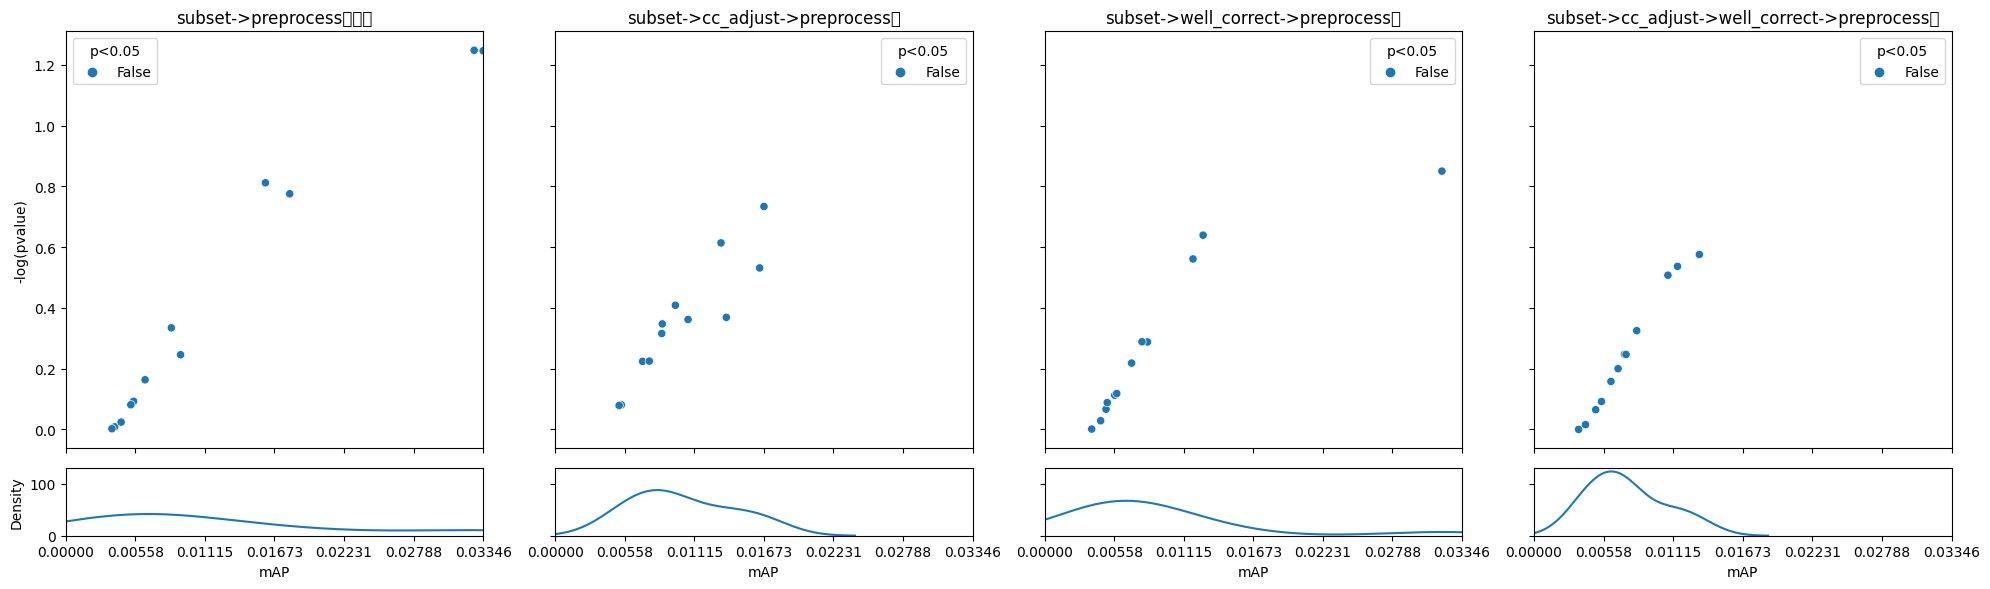

same_well_same_pert subset->preprocess			 mmAP: 0.229 p<0.05: 0.971 (2524/2600)
same_well_same_pert subset->cc_adjust->preprocess	 mmAP: 0.0818 p<0.05: 0.401 (1043/2600)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.306 p<0.05: 0.947 (2462/2600)
same_well_same_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.545 p<0.05: 0.99 (2573/2600)


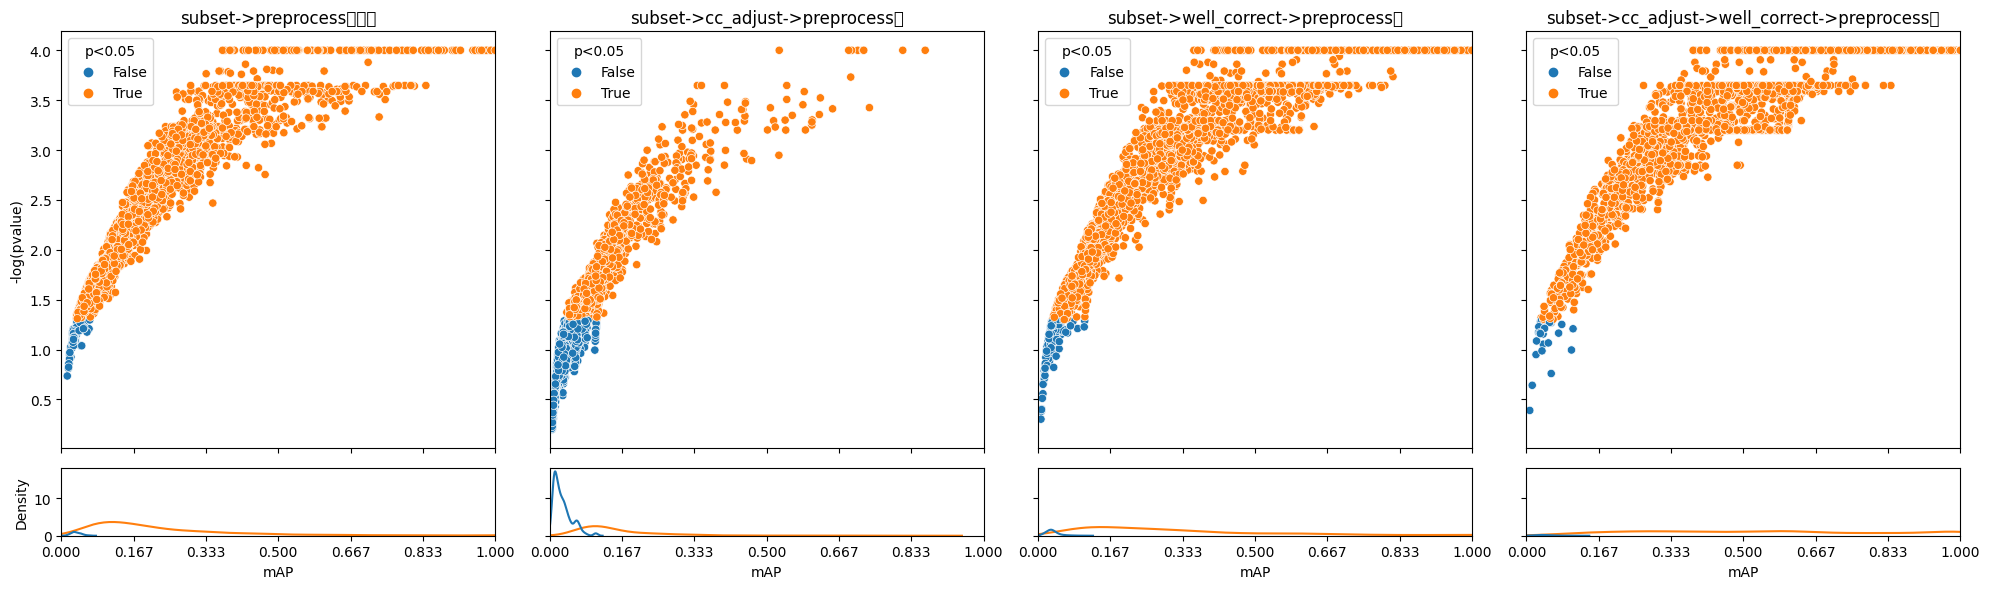

In [11]:
for config in metrics_low_ccv_df.config.unique():
    config_df = metrics_low_ccv_df[metrics_low_ccv_df.config==config]
    plot_map_per_config(config_df, config, figsave_path=FIGSAVE_PATH / "low_ccv")

#### High CCV

same_well_diff_pert subset->preprocess			 mmAP: 0.0636 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->cc_adjust->preprocess	 mmAP: 0.0583 p<0.05: 0.0217 (8/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.114 p<0.05: 0.25 (92/368)
same_well_diff_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.379 p<0.05: 0.723 (266/368)


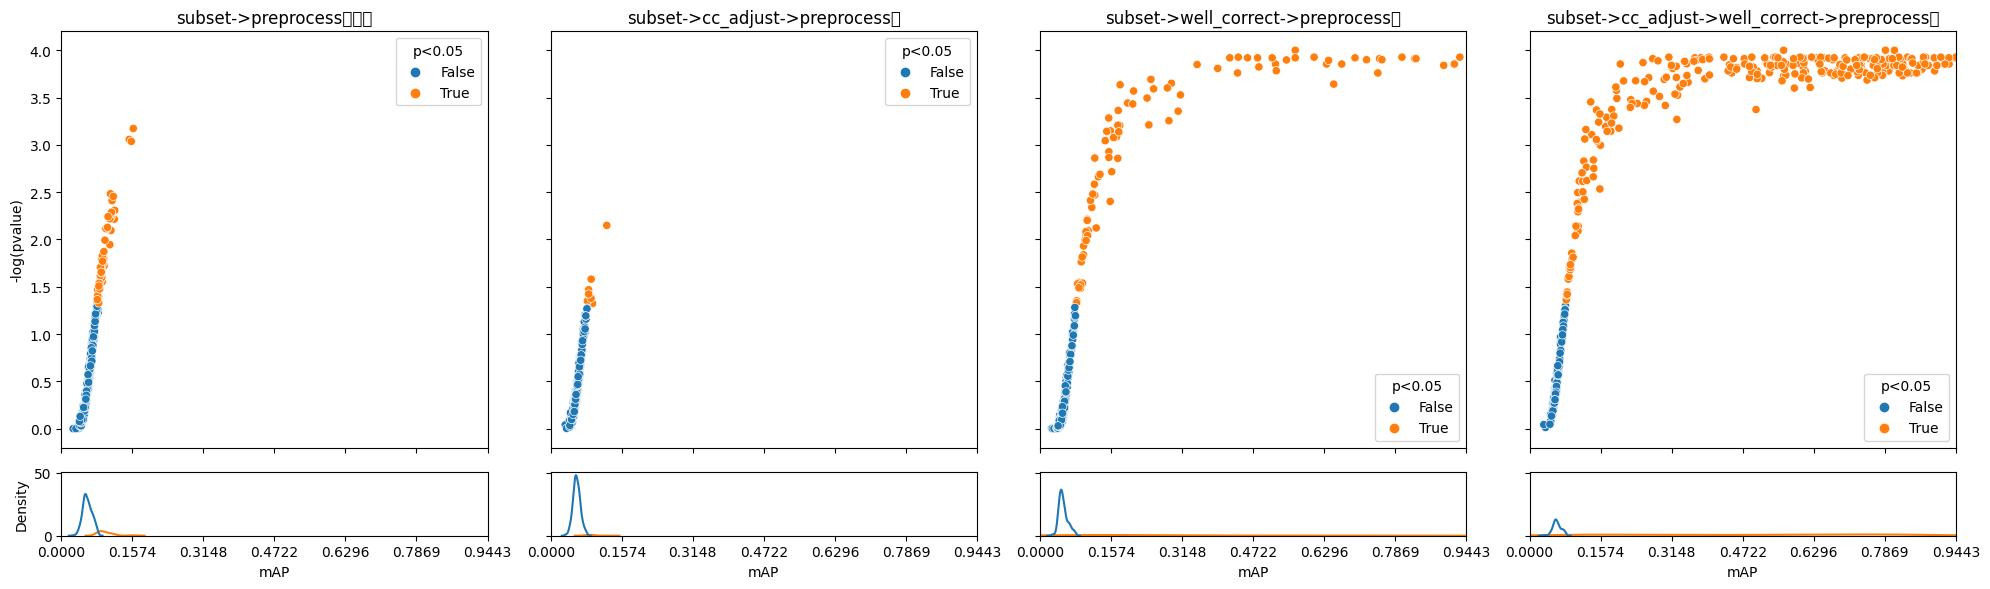

same_pert_diff_well subset->preprocess			 mmAP: 0.00854 p<0.05: 0.0 (0/25)
same_pert_diff_well subset->cc_adjust->preprocess	 mmAP: 0.025 p<0.05: 0.04 (1/25)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0202 p<0.05: 0.04 (1/25)
same_pert_diff_well subset->cc_adjust->well_correct->preprocess	 mmAP: 0.00877 p<0.05: 0.0 (0/25)


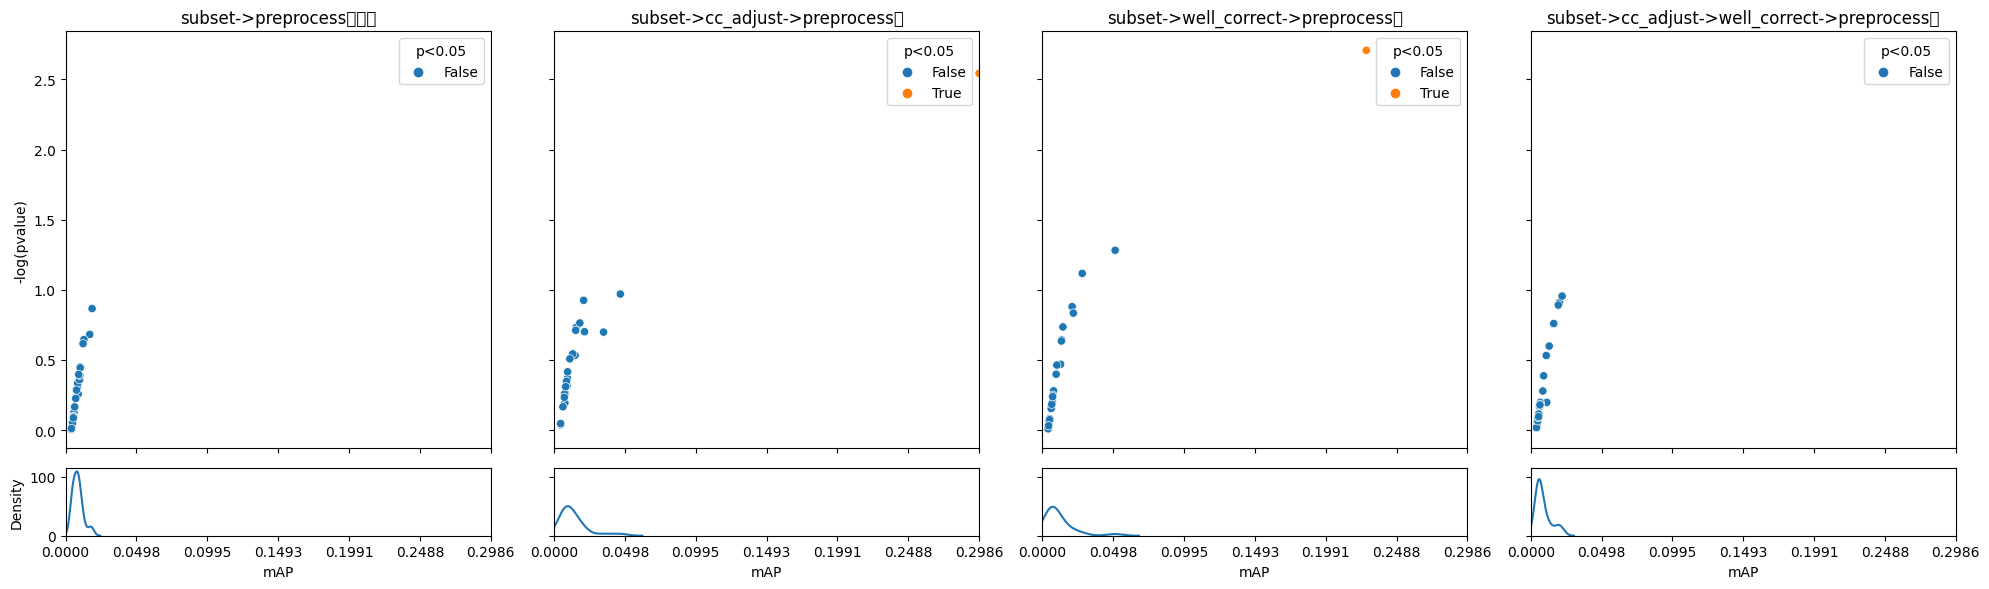

same_well_same_pert subset->preprocess			 mmAP: 0.113 p<0.05: 0.734 (773/1053)
same_well_same_pert subset->cc_adjust->preprocess	 mmAP: 0.0949 p<0.05: 0.457 (481/1053)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.239 p<0.05: 0.888 (935/1053)
same_well_same_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.522 p<0.05: 0.987 (1039/1053)


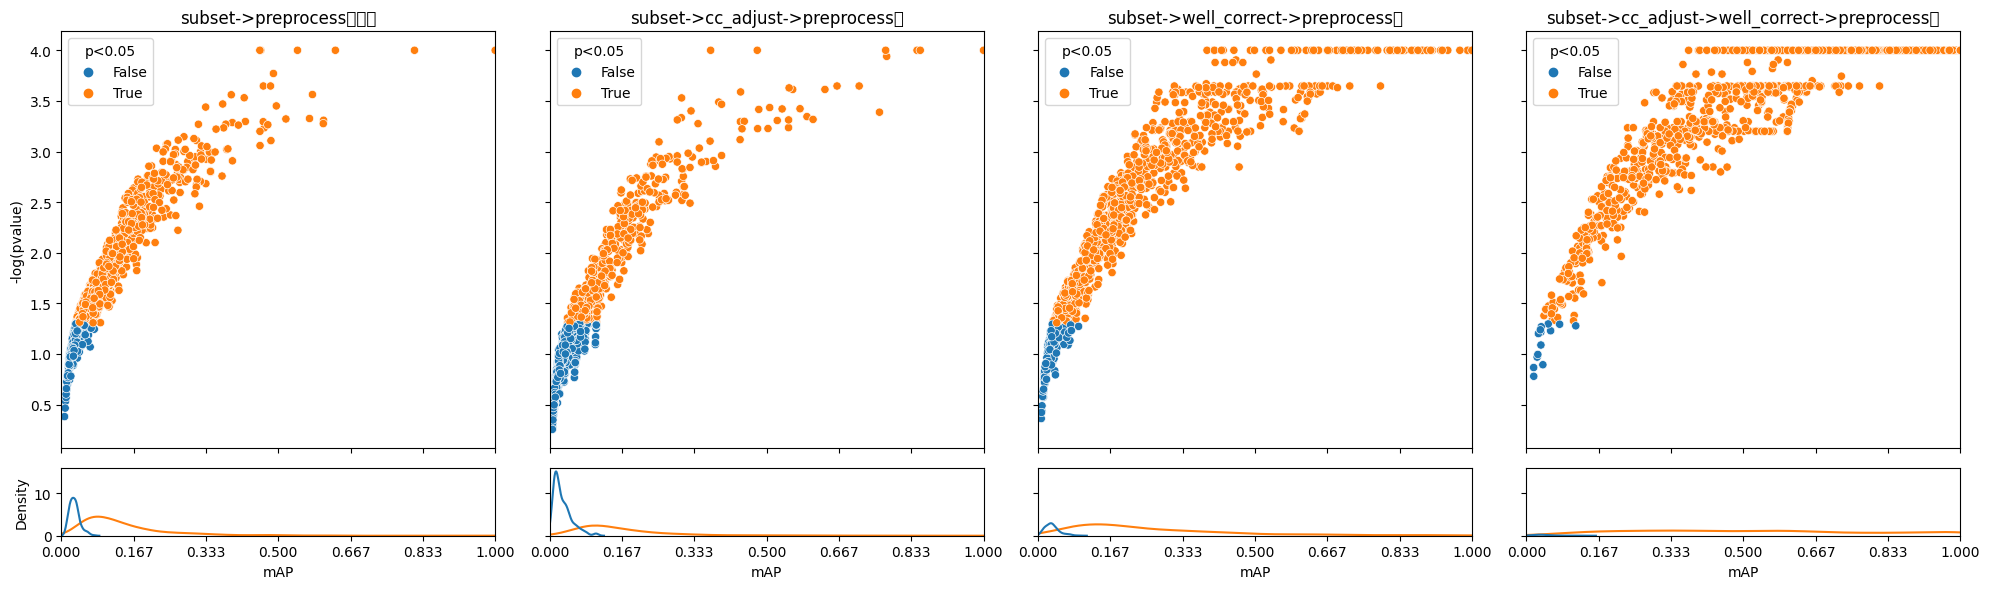

In [12]:
for config in metrics_high_ccv_df.config.unique():
    config_df = metrics_high_ccv_df[metrics_high_ccv_df.config==config]
    plot_map_per_config(config_df, config, figsave_path=FIGSAVE_PATH / "high_ccv")

### Explore relationship between cell count variability and mAP

In [13]:
cell_count_cvar = pd.read_csv("../1.load/output/cell_count_per_orf.csv")
cell_count_cvar

,Metadata_JCP2022,Metadata_Cell_Count_CoV
0,JCP2022_900006,0.052080
1,JCP2022_900008,0.133191
2,JCP2022_900012,0.052447
3,JCP2022_900014,0.084927
4,JCP2022_900015,0.087774
...,...,...
3611,JCP2022_915120,0.098188
3612,JCP2022_915123,0.076138
3613,JCP2022_915125,0.110349
3614,JCP2022_915126,0.052932


#### Merge metrics and cell count CoV on JCP id

The only difference is metrics have `NaNs` due to `same_well_diff_pert`

In [14]:
print("Diff:", set(metrics_df.Metadata_JCP2022.unique()).symmetric_difference(set(cell_count_cvar.Metadata_JCP2022.unique())))

metrics_df = metrics_df.merge(cell_count_cvar, on="Metadata_JCP2022", how="left")
metrics_df.head(3)

Diff: {nan}


,Metadata_Well,mAP,-log(pvalue),-log(qvalue),config,subset,p<0.05,Metadata_JCP2022,Metadata_Cell_Count_CoV
0,A01,0.117580,2.214167,0.809879,same_well_diff_pert,subset->preprocess\t\t\t,True,NaN,NaN
1,A02,0.110061,2.094943,0.801806,same_well_diff_pert,subset->preprocess\t\t\t,True,NaN,NaN
2,A03,0.090878,1.553550,0.583077,same_well_diff_pert,subset->preprocess\t\t\t,True,NaN,NaN


same_well_diff_pert subset->preprocess			 mmAP: 0.0636 p<0.05: 0.139 (51/368)
same_well_diff_pert subset->cc_adjust->preprocess	 mmAP: 0.0583 p<0.05: 0.0217 (8/368)
same_well_diff_pert subset->well_correct->preprocess	 mmAP: 0.114 p<0.05: 0.25 (92/368)
same_well_diff_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.379 p<0.05: 0.723 (266/368)


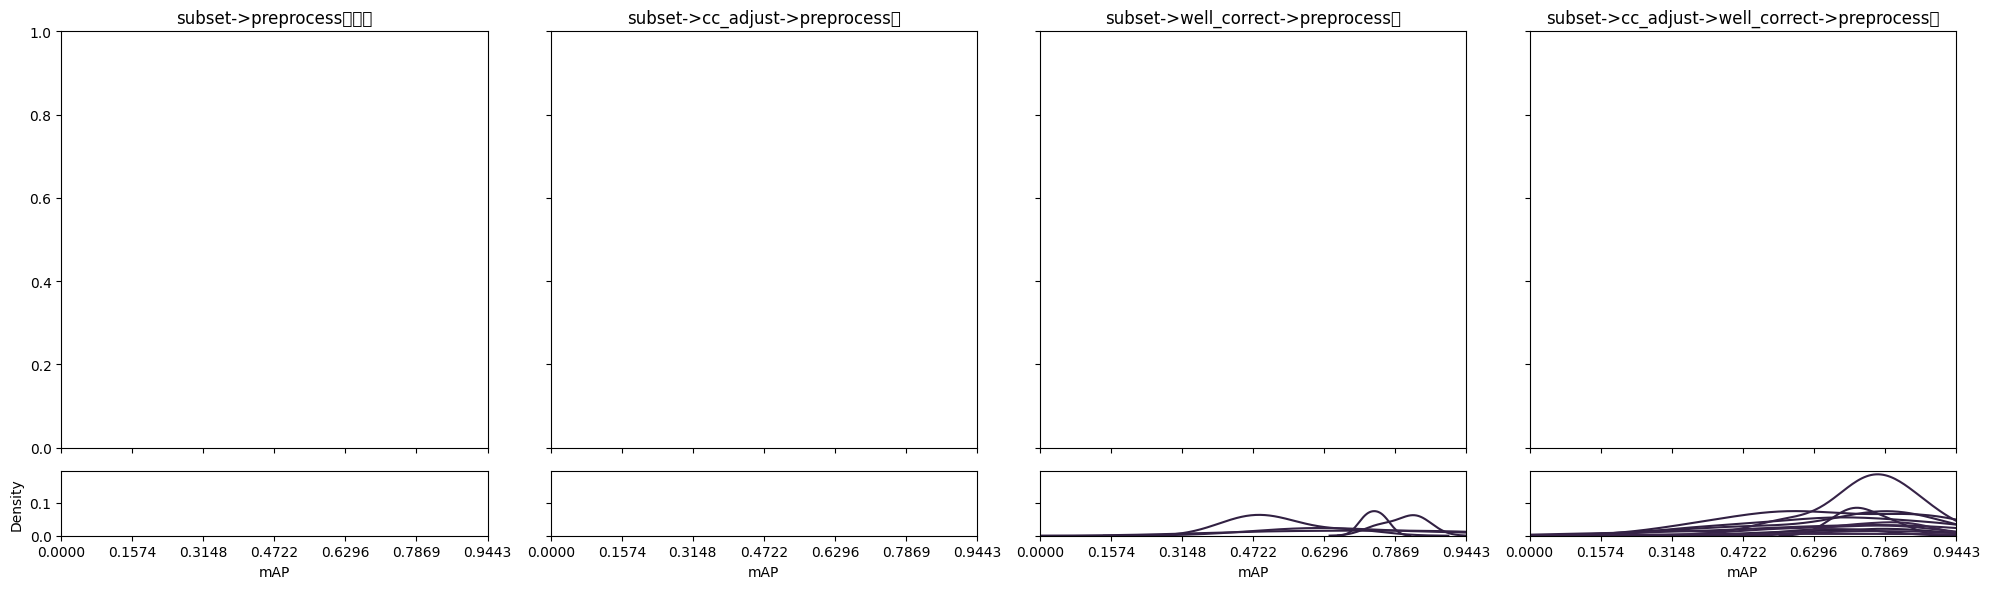

same_pert_diff_well subset->preprocess			 mmAP: 0.00974 p<0.05: 0.0 (0/37)
same_pert_diff_well subset->cc_adjust->preprocess	 mmAP: 0.0202 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->well_correct->preprocess	 mmAP: 0.0166 p<0.05: 0.027 (1/37)
same_pert_diff_well subset->cc_adjust->well_correct->preprocess	 mmAP: 0.00834 p<0.05: 0.0 (0/37)


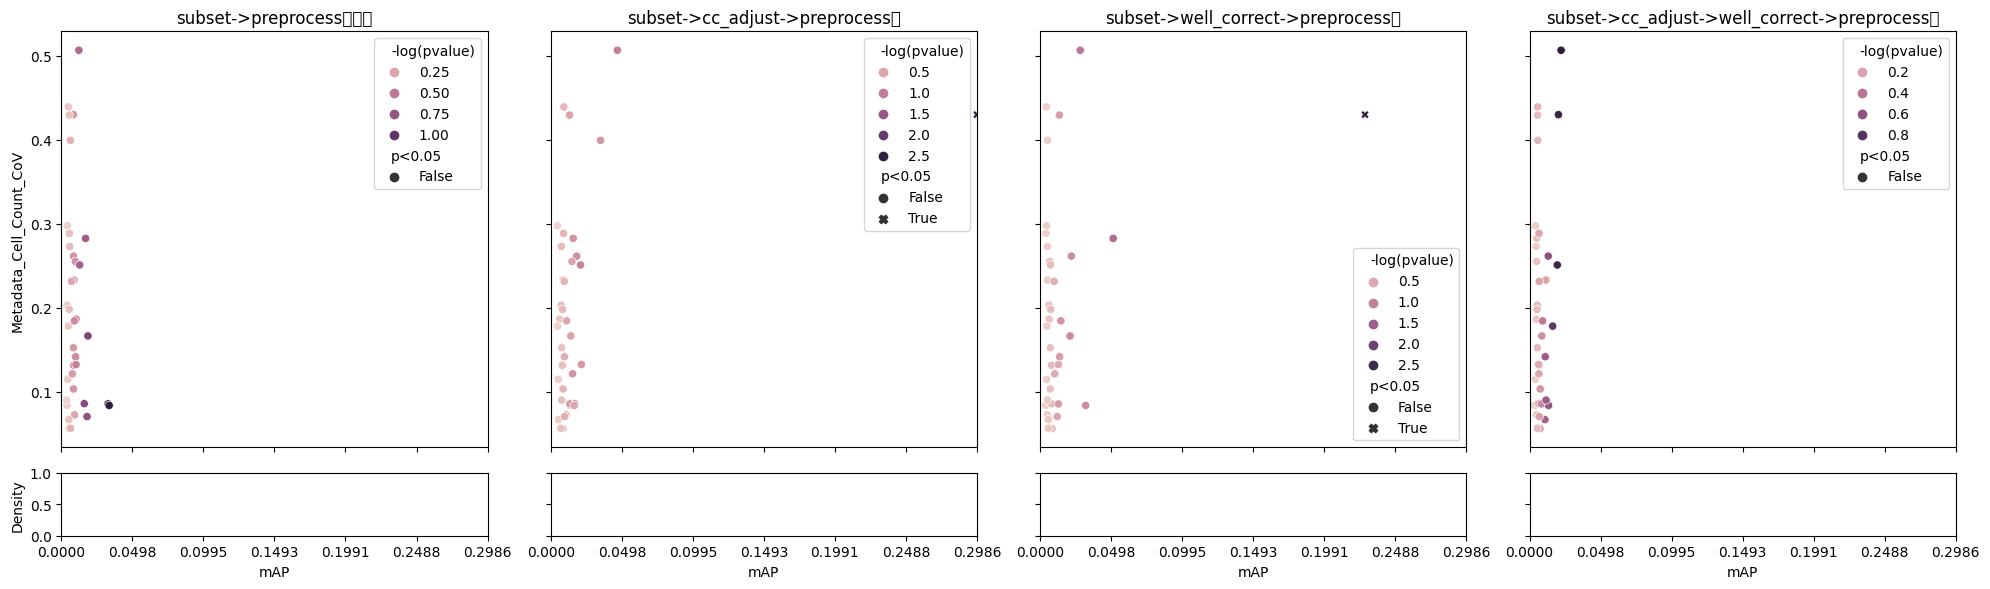

same_well_same_pert subset->preprocess			 mmAP: 0.195 p<0.05: 0.903 (3297/3653)
same_well_same_pert subset->cc_adjust->preprocess	 mmAP: 0.0856 p<0.05: 0.417 (1524/3653)
same_well_same_pert subset->well_correct->preprocess	 mmAP: 0.286 p<0.05: 0.93 (3397/3653)
same_well_same_pert subset->cc_adjust->well_correct->preprocess	 mmAP: 0.538 p<0.05: 0.989 (3612/3653)


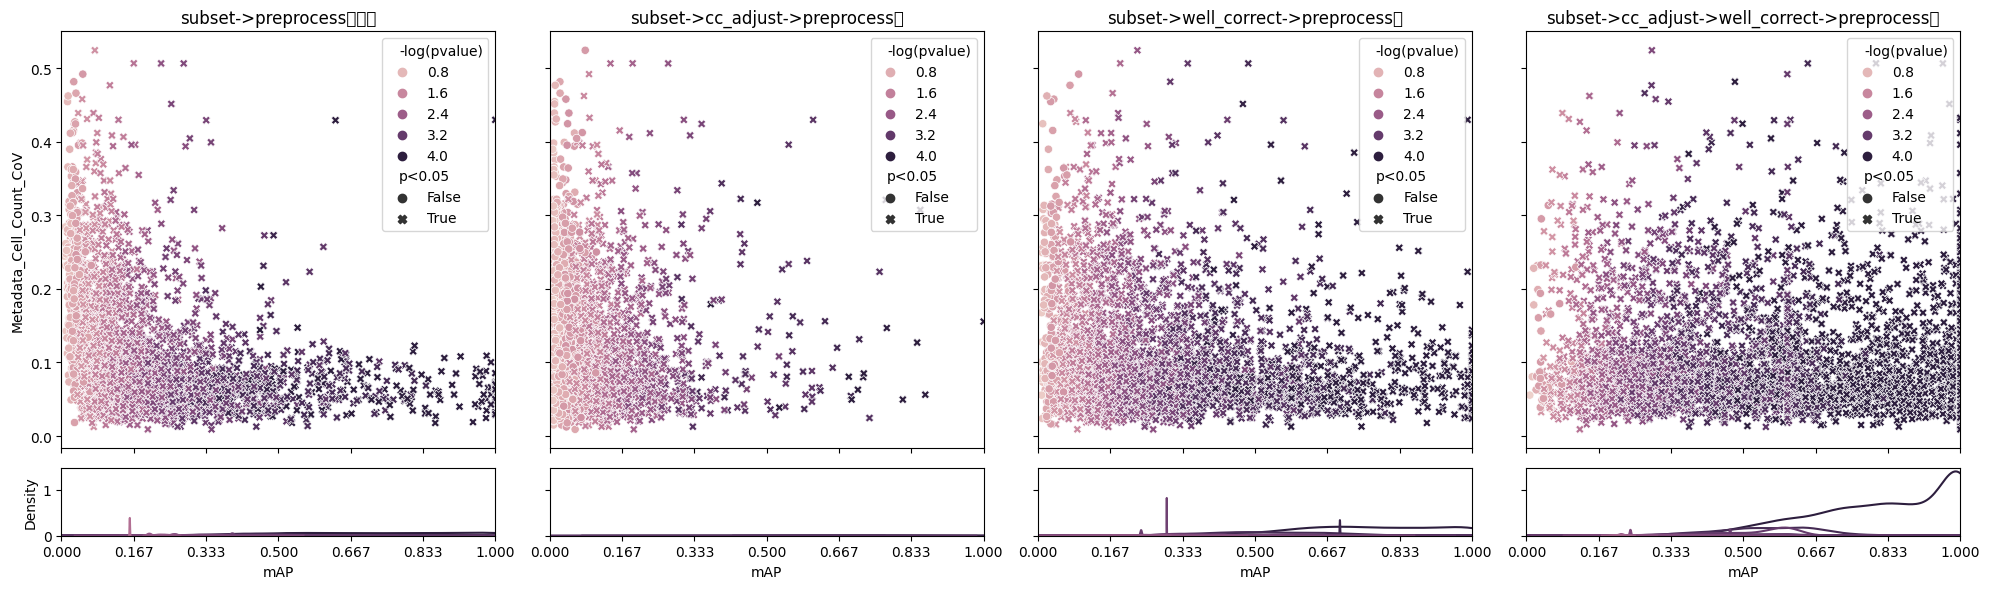

In [15]:
for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    plot_map_per_config(config_df, config, y_col="Metadata_Cell_Count_CoV",
                        hue_col="-log(pvalue)", style_col="p<0.05",
                         figsave_path=FIGSAVE_PATH / "map_vs_ccv")

same_well_diff_pert subset->preprocess			 mmAP: 0.0636 p<0.05: 0.139 (51/368)


ValueError: Axis limits cannot be NaN or Inf

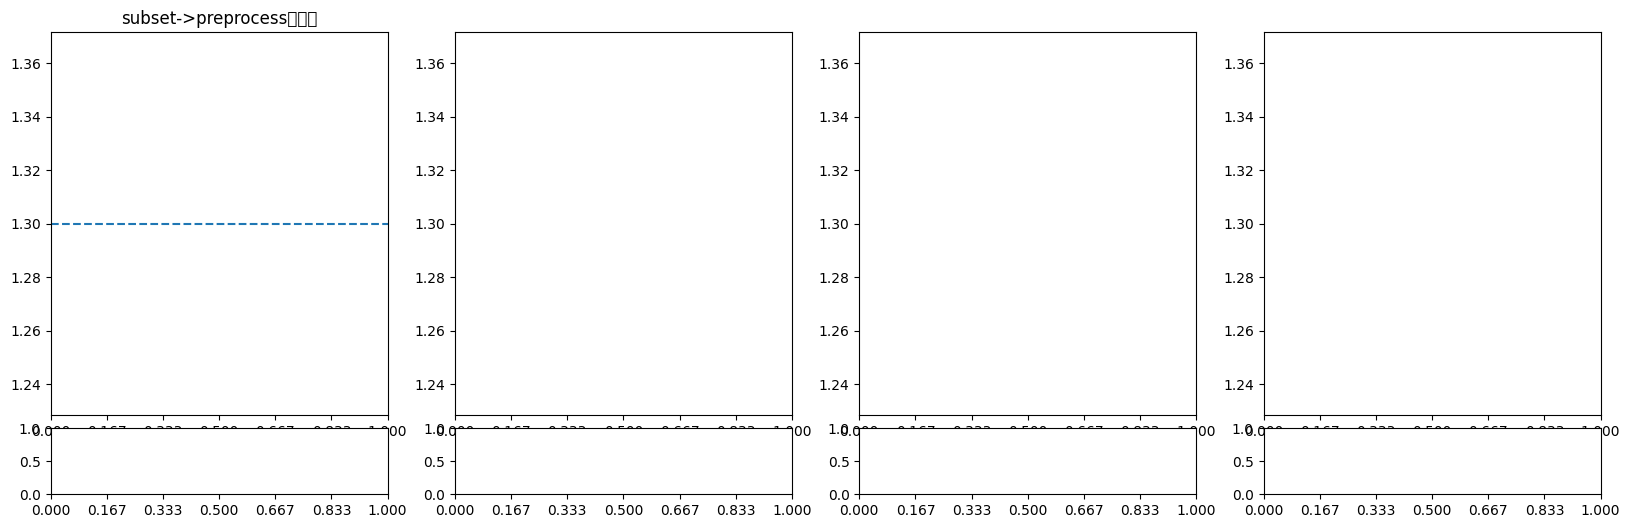

In [16]:
for config in metrics_df.config.unique():
    config_df = metrics_df[metrics_df.config==config]
    plot_map_per_config(config_df, config, x_col="Metadata_Cell_Count_CoV", hue_col="mAP", ax_line=1.3,
                        figsave_path=FIGSAVE_PATH / "pvalue_vs_ccv")